In [1]:
import random
import re

from default import PROJECT_HOME
%cd {PROJECT_HOME}

/Users/aflamant/Documents/courses/2024-2025/mémoire/03-code/memoire


In [2]:
from dataset.structural.analysis import LinearAnalysis
from dataset.structural.structure import PrattTruss
from dataset.generator import PrattTrussGenerator
from display import *
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
from typing import Dict, Iterable

1590.84


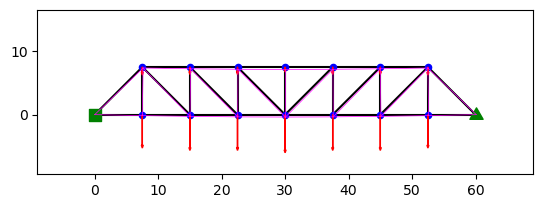

In [3]:
import numpy as np

n_panels = 8
l = 7.5
volumetric_weight = 78.5e3
params = {
    'n_panels': n_panels,
    'height': l,
    'length': n_panels * l,
    'volumetric_weight': volumetric_weight
}

a = .2
a_t = a
a_b = a
a_v = a
a_d = a

e_t = 200e9
e_b = 200e9
e_v = 200e9
e_d = 200e9

for i in range(8):
    params[f"A_{i}"] = a_b
    params[f"E_{i}"] = e_b
for i in range(8, 14):
    params[f"A_{i}"] = a_t
    params[f"E_{i}"] = e_t
for i in range(14, 21):
    params[f"A_{i}"] = a_v
    params[f"E_{i}"] = e_v
params[f"A_21"] = a_t
params[f"E_21"] = e_t
for i in range(22, 28):
    params[f"A_{i}"] = a_d
    params[f"E_{i}"] = e_d
params[f"A_28"] = a_t
params[f"E_28"] = e_t

for i in range(2 * n_panels):
    params[f"P_x_{i}"] = 0.
    params[f"P_y_{i}"] = 0.

for i in range(1, n_panels):
    params[f"P_y_{i}"] = -1000.e3

struct = PrattTruss()
struct.generate_model(params)
LinearAnalysis().run_analysis()
g = PrattTrussGenerator()
results = g.construct_result(params)
display_structure(def_scale=10)
print(f"{60 / np.abs(struct.nodes_displacements[:, 1]).max():.2f}")

In [4]:
K = results['stiffness_matrix'].reshape((int(results['stiffness_matrix'].__len__() ** .5),) * 2)
K[np.abs(K) < .1] = 0

In [5]:
K = results['stiffness_matrix'].reshape((int(results['stiffness_matrix'].__len__() ** .5),) * 2)
q = results['nodes_load'].reshape((-1, 1))
u = results['nodes_displacement'].reshape((-1, 1))

np.round(K @ u - q)

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [6]:
def plot(g, def_scale=5):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    for i, r in enumerate(g):
        if i >= 6:  # Since we have 2x3=6 subplots
            break

        display_structure(ax=axs[i], def_scale=def_scale)

    # After plotting all structures, adjust all axes to have same limits
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')

    # Find global min and max across all subplots
    for ax in axs:
        x_limits = ax.get_xlim()
        y_limits = ax.get_ylim()
        x_min = min(x_min, x_limits[0])
        x_max = max(x_max, x_limits[1])
        y_min = min(y_min, y_limits[0])
        y_max = max(y_max, y_limits[1])

    # Make the scale the same in both directions - take the wider range
    total_range = max(x_max - x_min, y_max - y_min)
    x_center = (x_max + x_min) / 2
    y_center = (y_max + y_min) / 2

    # Apply the same limits to all subplots
    for ax in axs:
        ax.set_xlim(x_center - total_range / 2, x_center + total_range / 2)
        ax.set_ylim(y_center - total_range / 2, y_center + total_range / 2)

        # Ensure aspect ratio is equal
        ax.set_aspect('equal')

    plt.tight_layout()

In [7]:
def sobol_sample(ranges: Dict | Iterable, size, seed=None):
    sampler = Sobol(d=len(ranges), scramble=True, seed=seed)
    sampling = sampler.random(n=size)

    if isinstance(ranges, dict):
        scaled_sampling = dict()
        for i, k in enumerate(ranges.keys()):
            min_val, max_val = ranges[k]
            scaled_sampling[k] = sampling[:, i] * (max_val - min_val) + min_val
    else:
        scaled_sampling = sampling.copy()
        for i, (min_val, max_val) in enumerate(ranges):
            scaled_sampling[:, i] = sampling[:, i] * (max_val - min_val) + min_val

    return scaled_sampling


def convert_bytecode_to_mask(bytecodes, n_bits):
    reference_masks = [2 ** i for i in range(7)]

    weights = [set([j + 1 for j, mask in enumerate(reference_masks) if bool((v & mask) >> j)])
               for v in range(128)]
    weights = [len(s) for s in weights]
    weights = [np.sum((np.array(weights) == i)) for i in weights]
    weights = [np.max(weights) / w for w in weights]

    targets = np.cumsum([0] + weights)

    for i in range(len(targets) - 1):
        mask = np.logical_and(targets[i] < bytecodes, bytecodes < targets[i + 1])
        bytecodes[mask] = i
    bytecodes = bytecodes.astype(int)
    masks = [set([j + 1 for j, mask in enumerate(reference_masks) if bool((v & mask) >> j)])
             for v in bytecodes]
    return masks

# Train set
We will generate sets of multiple size

In [7]:
g = PrattTrussGenerator()

In [8]:
def generate_dataset_uniform_ea(random_load_size, shared_load_size, filepath,
                                young_range=(150e9, 250e9), area_range=(1e-3, 5e-2), load_range=(-1_000.e3, 0.0)):
    params_ranges = {
        'e': young_range,
        'a': area_range,
        'b_P_y_1': (0, 1),
        'b_P_y_2': (0, 1),
        'b_P_y_3': (0, 1),
        'b_P_y_4': (0, 1),
        'b_P_y_5': (0, 1),
        'b_P_y_6': (0, 1),
        'b_P_y_7': (0, 1),
        'P_y_1': load_range,
        'P_y_2': load_range,
        'P_y_3': load_range,
        'P_y_4': load_range,
        'P_y_5': load_range,
        'P_y_6': load_range,
        'P_y_7': load_range,
    }

    size = random_load_size
    samples = sobol_sample(
        ranges=params_ranges,
        size=size,
    )

    results_iterator = []
    for i in range(size):
        params = {
            'n_panels': 8,
            'length': 60.0,
            'height': 7.5,
            'volumetric_weight': 78.5e3
        }
        params.update({f"A_{j}": samples['a'][i] for j in range(29)})
        params.update({f"E_{j}": samples['e'][i] for j in range(29)})
        params.update({f"P_x_{i}": 0. for i in range(16)})
        params.update({f"P_y_{i}": 0. for i in range(16)})

        for j in range(1, 8):
            trigger = True if samples[f'b_P_y_{j}'][i] >= .5 else False
            if trigger:
                params[f"P_y_{j}"] = samples[f"P_y_{j}"][i]

        struct = PrattTruss()
        struct.generate_model(params)
        LinearAnalysis().run_analysis()
        results_iterator.append(g.construct_result(params))

    params_ranges = {
        'e': young_range,
        'a': area_range,
        'b_P_y_1': (0, 1),
        'b_P_y_2': (0, 1),
        'b_P_y_3': (0, 1),
        'b_P_y_4': (0, 1),
        'b_P_y_5': (0, 1),
        'b_P_y_6': (0, 1),
        'b_P_y_7': (0, 1),
        'P_y': load_range,
    }

    size = shared_load_size
    samples = sobol_sample(
        ranges=params_ranges,
        size=size,
    )

    for i in range(size):
        params = {
            'n_panels': 8,
            'length': 60.0,
            'height': 7.5,
            'volumetric_weight': 78.5e3
        }
        params.update({f"A_{j}": samples['a'][i] for j in range(29)})
        params.update({f"E_{j}": samples['e'][i] for j in range(29)})
        params.update({f"P_x_{i}": 0. for i in range(16)})
        params.update({f"P_y_{i}": 0. for i in range(16)})

        for j in range(1, 8):
            trigger = True if samples[f'b_P_y_{j}'][i] >= .5 else False
            if trigger:
                params[f"P_y_{j}"] = samples[f"P_y"][i]

        struct = PrattTruss()
        struct.generate_model(params)
        LinearAnalysis().run_analysis()
        results_iterator.append(g.construct_result(params))

    random.shuffle(results_iterator)  # mixing up the two modes
    g.save_from_iterator(results_iterator, filepath, max_size=len(results_iterator))

In [25]:
def generate_dataset_non_uniform_ea(size,
                                    uniform_ea_ratio, random_ea_ratio, three_ea_ratio,
                                    random_load_ratio, shared_load_ratio, filepath,
                                    young_range=(150e9, 250e9), area_range=(1e-3, 5e-2), load_range=(-1_000.e3, 0.0)):
    if uniform_ea_ratio + random_ea_ratio + three_ea_ratio != 1.:
        raise ValueError("ea ratios must sum to 1")
    if random_load_ratio + shared_load_ratio != 1.:
        raise ValueError("load ratios must sum to 1")

    def routine(size, params_ranges, default_params=None):
        if default_params is None:
            default_params = {
                'n_panels': 8,
                'length': 60.0,
                'height': 7.5,
                'volumetric_weight': 78.5e3
            }

        samples = sobol_sample(
            ranges=params_ranges,
            size=size,
        )

        results_iterator = []
        for i in range(size):
            params = default_params.copy()
            if 'a' in samples:  # Uniform
                params.update({f"A_{j}": samples['a'][i] for j in range(29)})
                params.update({f"E_{j}": samples['e'][i] for j in range(29)})
            elif 'a_v' in samples:  # Uniform per class
                params.update({f"A_{j}": samples['a_h'][i] for j in range(8)})
                params.update({f"A_{j}": samples['a_h'][i] for j in range(8, 14)})
                params.update({f"A_{j}": samples['a_h'][i] for j in [21, 28]})
                params.update({f"A_{j}": samples['a_v'][i] for j in range(14, 21)})
                params.update({f"A_{j}": samples['a_d'][i] for j in range(22, 28)})

                params.update({f"E_{j}": samples['e_h'][i] for j in range(8)})
                params.update({f"E_{j}": samples['e_h'][i] for j in range(8, 14)})
                params.update({f"E_{j}": samples['e_h'][i] for j in [21, 28]})
                params.update({f"E_{j}": samples['e_v'][i] for j in range(14, 21)})
                params.update({f"E_{j}": samples['e_d'][i] for j in range(22, 28)})
            else:  # Non-uniform
                params.update({f"A_{j}": samples[f'a_{j}'][i] for j in range(29)})
                params.update({f"E_{j}": samples[f'e_{j}'][i] for j in range(29)})

            params.update({f"P_x_{i}": 0. for i in range(16)})
            params.update({f"P_y_{i}": 0. for i in range(16)})

            for j in range(1, 8):
                trigger = True if samples[f'b_P_y_{j}'][i] >= .5 else False
                if trigger:
                    if 'P_y' in samples:  # Uniform load
                        params[f"P_y_{j}"] = samples[f"P_y"][i]
                    else:  # Non-uniform load
                        params[f"P_y_{j}"] = samples[f"P_y_{j}"][i]

            struct = PrattTruss()
            struct.generate_model(params)
            LinearAnalysis().run_analysis()
            results_iterator.append(g.construct_result(params))

        return results_iterator

    results_iterator = []

    size_r = size * random_load_ratio
    # Random loads
    params_ranges = {f'e_{i}': young_range for i in range(29)}
    params_ranges.update({f'a_{i}': area_range for i in range(29)})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_r_r = int(random_ea_ratio * size_r)

    results_iterator += routine(size_r_r, params_ranges)

    params_ranges = {f'e': young_range}
    params_ranges.update({f'a': area_range})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_r_u = int(uniform_ea_ratio * size_r)

    results_iterator += routine(size_r_u, params_ranges)

    params_ranges = {f'e_{i}': young_range for i in ['h', 'v', 'd']}
    params_ranges.update({f'a_{i}': area_range for i in ['h', 'v', 'd']})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y_{i}': load_range for i in range(1, 9)})
    size_r_t = int(size_r - size_r_r - size_r_u)

    results_iterator += routine(size_r_t, params_ranges)

    size_u = size - size_r
    # Uniform loads
    params_ranges = {f'e_{i}': young_range for i in range(29)}
    params_ranges.update({f'a_{i}': area_range for i in range(29)})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_u_r = int(random_ea_ratio * size_u)

    results_iterator += routine(size_u_r, params_ranges)

    params_ranges = {f'e': young_range}
    params_ranges.update({f'a': area_range})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_u_u = int(uniform_ea_ratio * size_u)
    results_iterator += routine(size_u_u, params_ranges)

    params_ranges = {f'e_{i}': young_range for i in ['h', 'v', 'd']}
    params_ranges.update({f'a_{i}': area_range for i in ['h', 'v', 'd']})
    params_ranges.update({f'b_P_y_{i}': (0, 1) for i in range(1, 9)})
    params_ranges.update({f'P_y': load_range})
    size_u_t = int(size_u - size_u_r - size_u_u)

    results_iterator += routine(size_u_t, params_ranges)

    random.shuffle(results_iterator)  # mixing up all modes
    g.save_from_iterator(results_iterator, filepath, max_size=len(results_iterator))

    return results_iterator

In [26]:
if True:
    for size in [100, 200, 500, 1_000, 2_000, 10_000, 20_000, 50_000, 100_000]:
        print(f"Generating data set of size {size}\n   ", end='')
        generate_dataset_non_uniform_ea(size,
                                        .3, .2, .5,
                                        .8, .2,
                                        f'data/dataset/pratt_truss_bridge/multiple_ea/train_{size}.hdf5')

Generating data set of size 100
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_100.hdf5
Generating data set of size 200
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_200.hdf5
Generating data set of size 500
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_500.hdf5
Generating data set of size 1000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_1000.hdf5
Generating data set of size 2000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_2000.hdf5
Generating data set of size 10000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_10000.hdf5
Generating data set of size 20000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_20000.hdf5
Generating data set of size 50000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/train_50000.hdf5
Generating data set of size 100000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_

In [9]:
if False:
    for size in [100, 200, 500, 1_000, 2_000, 10_000, 20_000, 50_000, 100_000]:
        size_1 = int(size * .8)
        size_2 = int(size * .2)
        print(f"Generating data set of size {size}\n   ", end='')
        generate_dataset_uniform_ea(size_1, size_2, f'data/dataset/pratt_truss_bridge/single_ea/train_{size}.hdf5')

Generating data set of size 100
   

/Users/aflamant/miniconda3/envs/x86Memoire/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_100.hdf5
Generating data set of size 200
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_200.hdf5
Generating data set of size 500
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_500.hdf5
Generating data set of size 1000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_1000.hdf5
Generating data set of size 2000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_2000.hdf5
Generating data set of size 10000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_10000.hdf5
Generating data set of size 20000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_20000.hdf5
Generating data set of size 50000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_50000.hdf5
Generating data set of size 100000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/train_100000.hdf5


# Test set

In [10]:
if False:
    for size in [1_000, 2_000, 10_000, 20_000]:
        print(f"Generating data set of size {size}\n   ", end='')
        size_1 = int(size * .8)
        size_2 = int(size * .2)
        generate_dataset_uniform_ea(size_1, size_2, f'data/dataset/pratt_truss_bridge/single_ea/test_{size}.hdf5')

Generating data set of size 1000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/test_1000.hdf5
Generating data set of size 2000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/test_2000.hdf5
Generating data set of size 10000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/test_10000.hdf5
Generating data set of size 20000
   Dataset saved to data/dataset/pratt_truss_bridge/single_ea/test_20000.hdf5


In [27]:
if True:
    for size in [1_000, 2_000, 10_000, 20_000]:
        print(f"Generating data set of size {size}\n   ", end='')
        generate_dataset_non_uniform_ea(size,
                                        .3, .2, .5,
                                        .8, .2,
                                        f'data/dataset/pratt_truss_bridge/multiple_ea/test_{size}.hdf5')

Generating data set of size 1000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/test_1000.hdf5
Generating data set of size 2000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/test_2000.hdf5
Generating data set of size 10000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/test_10000.hdf5
Generating data set of size 20000
   Dataset saved to data/dataset/pratt_truss_bridge/multiple_ea/test_20000.hdf5
